### Data Dictionary

This dataset contains the following 17 variables:

    letter = the letter that the image corresponds to (A, B, P or R)
    xbox = the horizontal position of where the smallest box covering the letter shape begins.
    ybox = the vertical position of where the smallest box covering the letter shape begins.
    width = the width of this smallest box.
    height = the height of this smallest box.
    onpix = the total number of "on" pixels in the character image
    xbar = the mean horizontal position of all of the "on" pixels
    ybar = the mean vertical position of all of the "on" pixels
    x2bar = the mean squared horizontal position of all of the "on" pixels in the image
    y2bar = the mean squared vertical position of all of the "on" pixels in the image
    xybar = the mean of the product of the horizontal and vertical position of all of the "on" pixels in the image
    x2ybar = the mean of the product of the squared horizontal position and the vertical position of all of the "on" pixels
    xy2bar = the mean of the product of the horizontal position and the squared vertical position of all of the "on" pixels
    xedge = the mean number of edges (the number of times an "off" pixel is followed by an "on" pixel, or the image boundary is hit) as the image is scanned from left to right, along the whole vertical length of the image
    xedgeycor = the mean of the product of the number of horizontal edges at each vertical position and the vertical position
    yedge = the mean number of edges as the images is scanned from top to bottom, along the whole horizontal length of the image
    yedgexcor = the mean of the product of the number of vertical edges at each horizontal position and the horizontal position


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance, plot_tree

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score, roc_auc_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("letters_ABPR.csv")

In [3]:
df

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgeycor,yedge,yedgexcor
0,B,4,2,5,4,4,8,7,6,6,7,6,6,2,8,7,10
1,A,1,1,3,2,1,8,2,2,2,8,2,8,1,6,2,7
2,R,5,9,5,7,6,6,11,7,3,7,3,9,2,7,5,11
3,B,5,9,7,7,10,9,8,4,4,6,8,6,6,11,8,7
4,P,3,6,4,4,2,4,14,8,1,11,6,3,0,10,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,A,2,3,3,1,1,6,2,2,1,5,2,8,1,6,1,7
3112,A,3,9,5,6,2,6,5,3,1,6,1,8,2,7,2,7
3113,R,2,3,3,2,2,7,7,5,5,7,5,6,2,7,4,8
3114,P,2,1,3,2,1,4,10,3,5,10,8,5,0,9,3,7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116 entries, 0 to 3115
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   letter     3116 non-null   object
 1   xbox       3116 non-null   int64 
 2   ybox       3116 non-null   int64 
 3   width      3116 non-null   int64 
 4   height     3116 non-null   int64 
 5   onpix      3116 non-null   int64 
 6   xbar       3116 non-null   int64 
 7   ybar       3116 non-null   int64 
 8   x2bar      3116 non-null   int64 
 9   y2bar      3116 non-null   int64 
 10  xybar      3116 non-null   int64 
 11  x2ybar     3116 non-null   int64 
 12  xy2bar     3116 non-null   int64 
 13  xedge      3116 non-null   int64 
 14  xedgeycor  3116 non-null   int64 
 15  yedge      3116 non-null   int64 
 16  yedgexcor  3116 non-null   int64 
dtypes: int64(16), object(1)
memory usage: 414.0+ KB


In [5]:
df.describe(include='all')

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgeycor,yedge,yedgexcor
count,3116,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.914955,7.051348,5.186457,5.275674,3.868742,7.468549,7.197047,4.706354,3.903402,8.491335,4.519576,6.711168,2.913350,7.762837,4.600449,8.417843
std,NaN,1.834611,3.358026,1.818636,2.245609,2.167564,1.876775,2.808552,2.232858,1.845903,2.031752,1.970228,2.003693,1.780815,1.644070,2.022630,1.655185
min,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,NaN,3.000000,5.000000,4.000000,4.000000,2.000000,6.000000,6.000000,3.000000,2.000000,7.000000,3.000000,6.000000,2.000000,7.000000,3.000000,7.000000
50%,NaN,4.000000,7.000000,5.000000,6.000000,4.000000,7.000000,7.000000,4.000000,4.000000,8.000000,5.000000,7.000000,2.000000,8.000000,4.000000,8.000000
75%,NaN,5.000000,9.000000,6.000000,7.000000,5.000000,8.000000,9.000000,6.000000,5.000000,10.000000,6.000000,8.000000,4.000000,9.000000,6.000000,10.000000


In [6]:
df.shape

(3116, 17)

In [7]:
df.columns

Index(['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar', 'ybar',
       'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge', 'xedgeycor',
       'yedge', 'yedgexcor'],
      dtype='object')

### Data Visualization

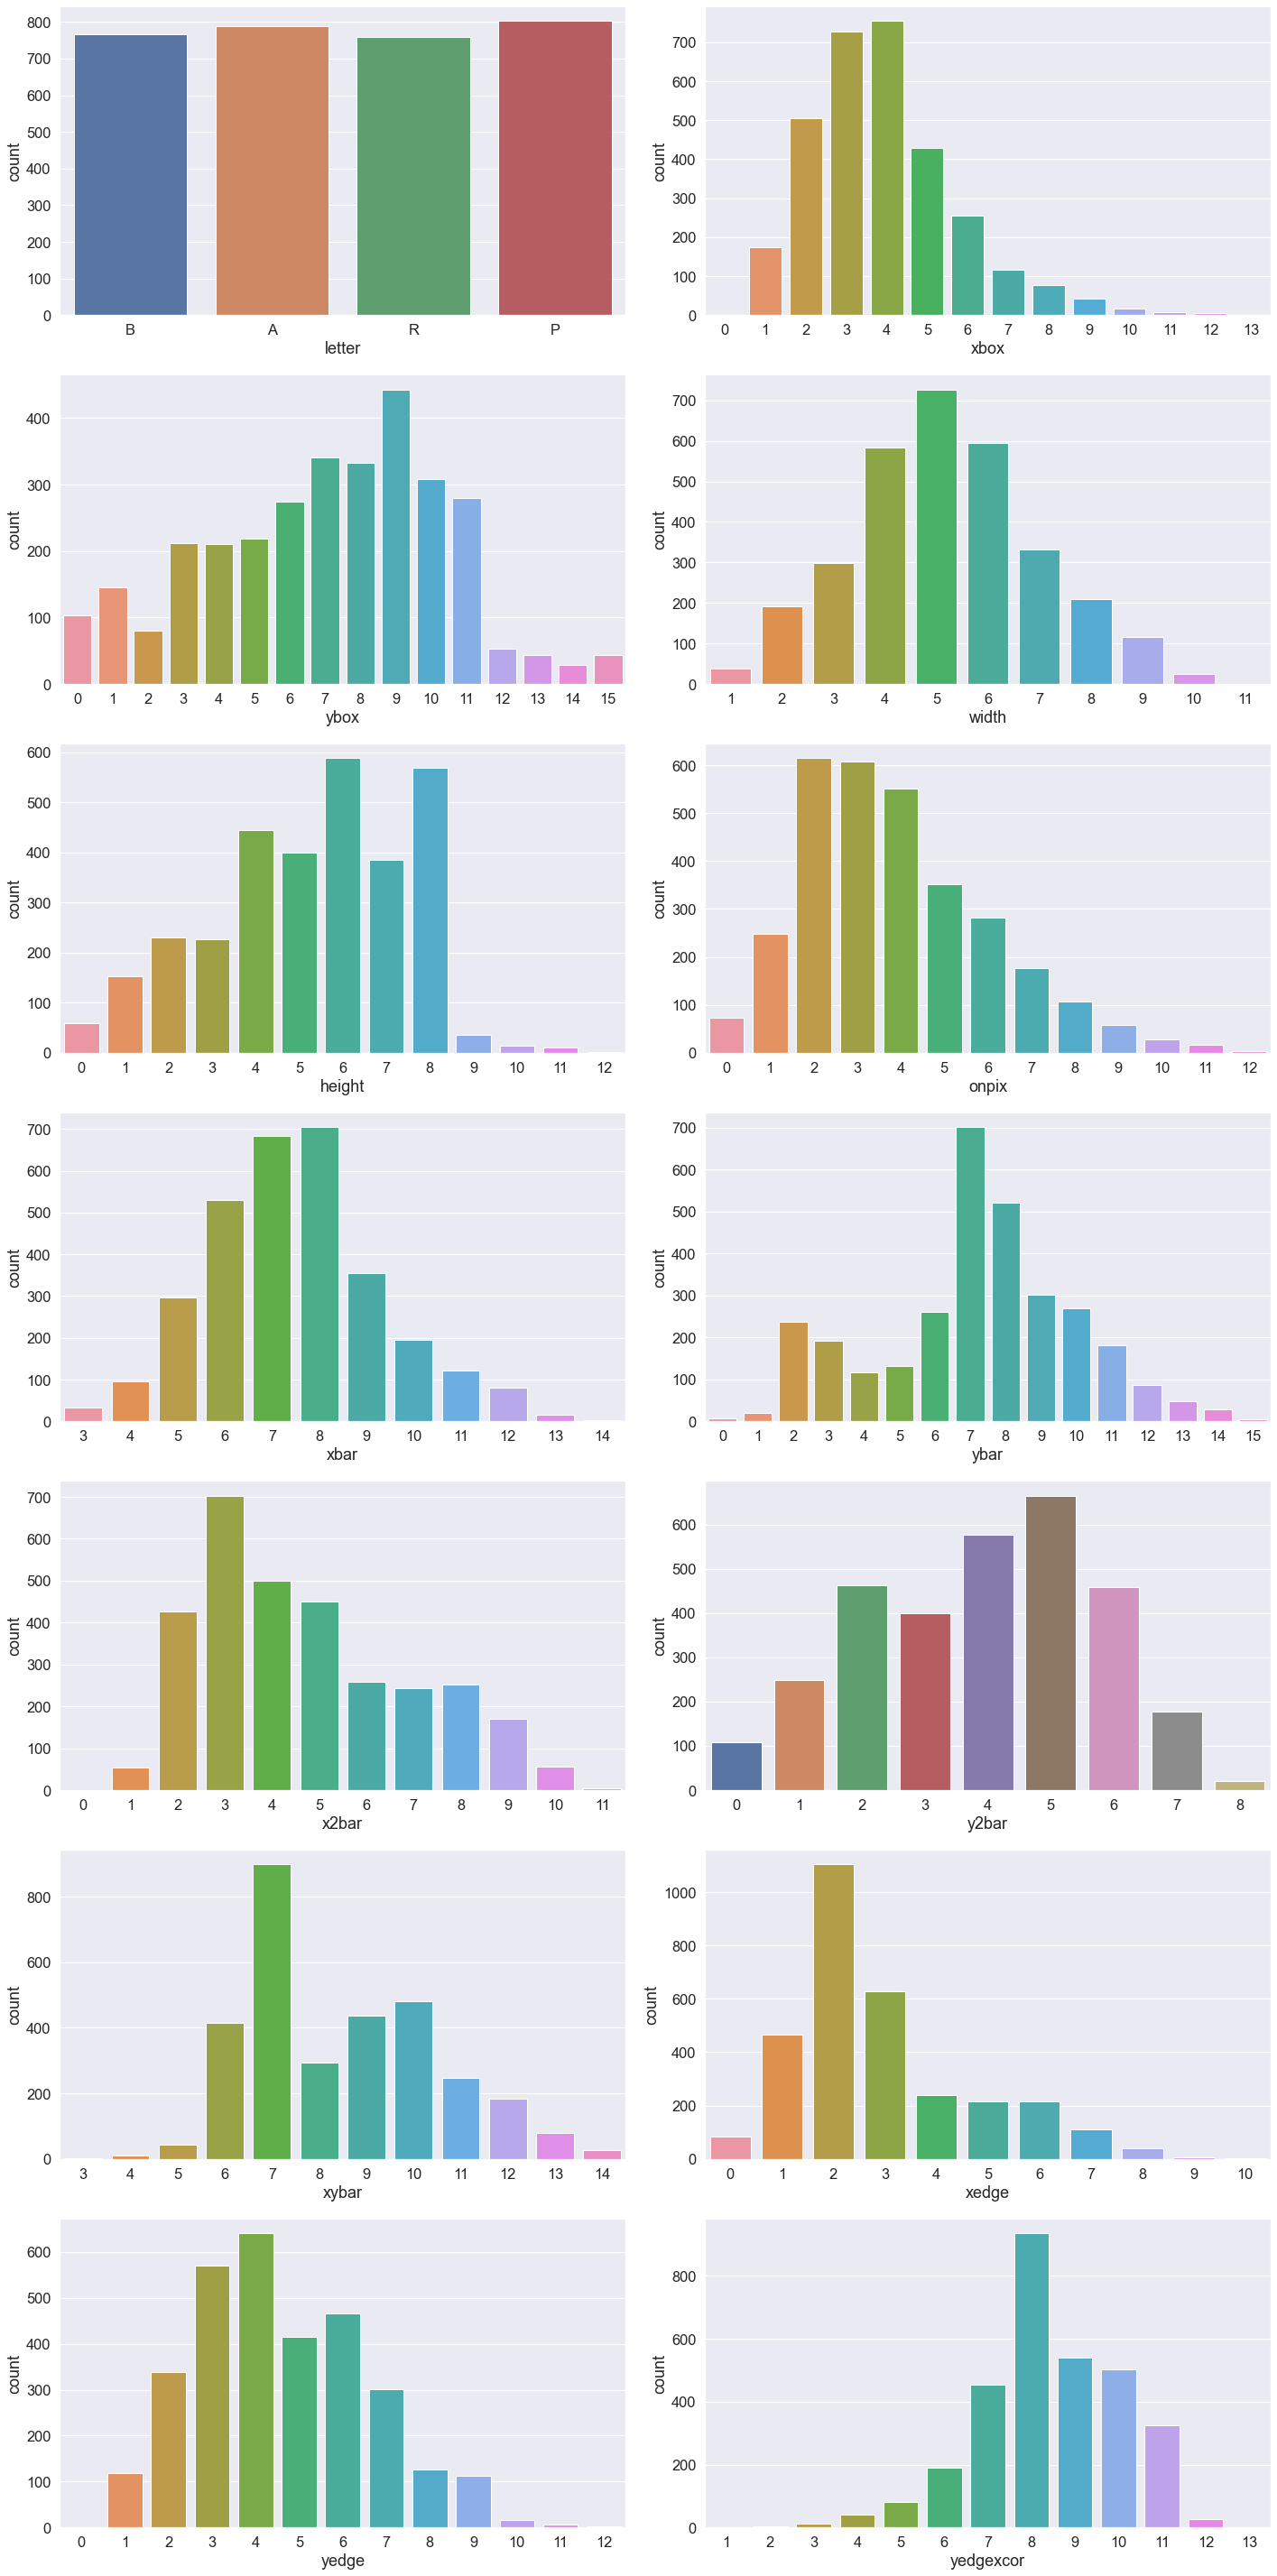

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.letter)
plt.subplot(7,2,2)
sns.countplot(df.xbox)
plt.subplot(7,2,3)
sns.countplot(df.ybox)
plt.subplot(7,2,4)
sns.countplot(df.width)
plt.subplot(7,2,5)
sns.countplot(df.height)
plt.subplot(7,2,6)
sns.countplot(df.onpix)
plt.subplot(7,2,7)
sns.countplot(df.xbar)
plt.subplot(7,2,8)
sns.countplot(df.ybar)
plt.subplot(7,2,9)
sns.countplot(df.x2bar)
plt.subplot(7,2,10)
sns.countplot(df.y2bar)
plt.subplot(7,2,11)
sns.countplot(df.xybar)
plt.subplot(7,2,12)
sns.countplot(df.xedge)
plt.subplot(7,2,13)
sns.countplot(df.yedge)
plt.subplot(7,2,14)
sns.countplot(df.yedgexcor)

plt.tight_layout()
plt.show()

In [9]:
df.corr()

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgeycor,yedge,yedgexcor
xbox,1.000000,0.789277,0.809225,0.681672,0.607094,0.088683,0.114466,0.107300,0.277600,0.254602,0.087454,0.006939,0.553211,0.058235,0.416830,0.030630
ybox,0.789277,1.000000,0.735524,0.835300,0.596915,0.175892,-0.005430,0.065464,0.200659,0.216697,-0.040280,0.087705,0.436867,-0.031694,0.316721,0.031486
width,0.809225,0.735524,1.000000,0.754301,0.764393,0.246404,-0.019074,-0.136482,0.255435,0.184669,-0.029555,0.007207,0.523308,0.058923,0.300231,-0.082627
height,0.681672,0.835300,0.754301,1.000000,0.735362,0.082686,0.057199,0.144519,0.165810,0.039188,0.046632,0.061438,0.434090,0.092842,0.366204,0.003288
onpix,0.607094,0.596915,0.764393,0.735362,1.000000,0.124972,0.074016,0.029377,0.326674,-0.100453,0.311173,0.057571,0.641098,0.168548,0.571996,-0.075977
xbar,0.088683,0.175892,0.246404,0.082686,0.124972,1.000000,-0.688381,-0.556648,0.002690,0.198574,-0.485193,0.425964,0.228079,-0.459736,-0.140018,0.109022
ybar,0.114466,-0.005430,-0.019074,0.057199,0.074016,-0.688381,1.000000,0.565528,0.223870,0.256276,0.605795,-0.664856,-0.150567,0.637028,0.208153,0.062045
x2bar,0.107300,0.065464,-0.136482,0.144519,0.029377,-0.556648,0.565528,1.000000,0.223120,-0.131651,0.432251,-0.203086,-0.134608,0.296281,0.502514,0.306654
y2bar,0.277600,0.200659,0.255435,0.165810,0.326674,0.002690,0.223870,0.223120,1.000000,0.049637,0.392133,-0.162912,0.120308,0.107222,0.577788,0.312565
xybar,0.254602,0.216697,0.184669,0.039188,-0.100453,0.198574,0.256276,-0.131651,0.049637,1.000000,0.038537,-0.467212,-0.193720,0.281696,-0.272969,0.084510


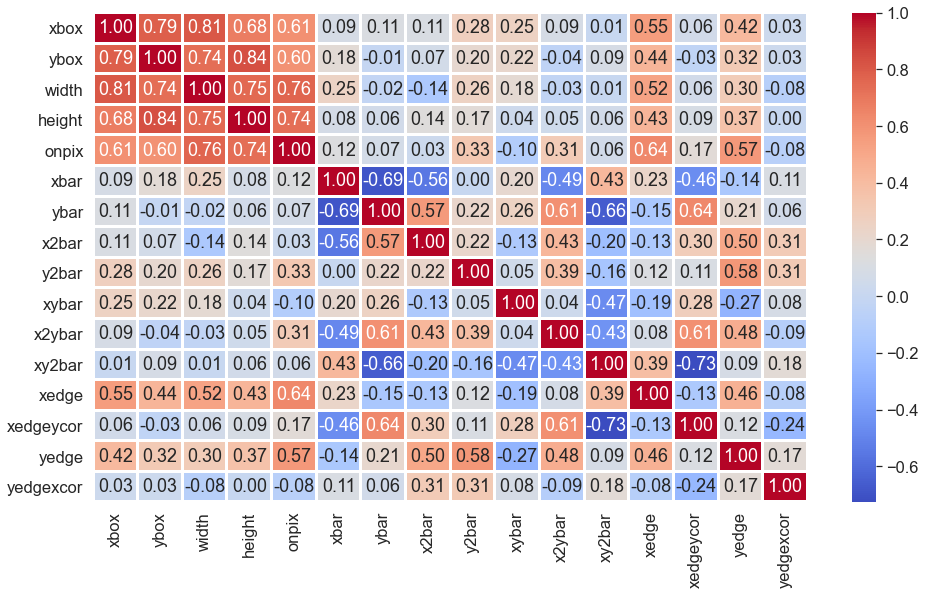

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

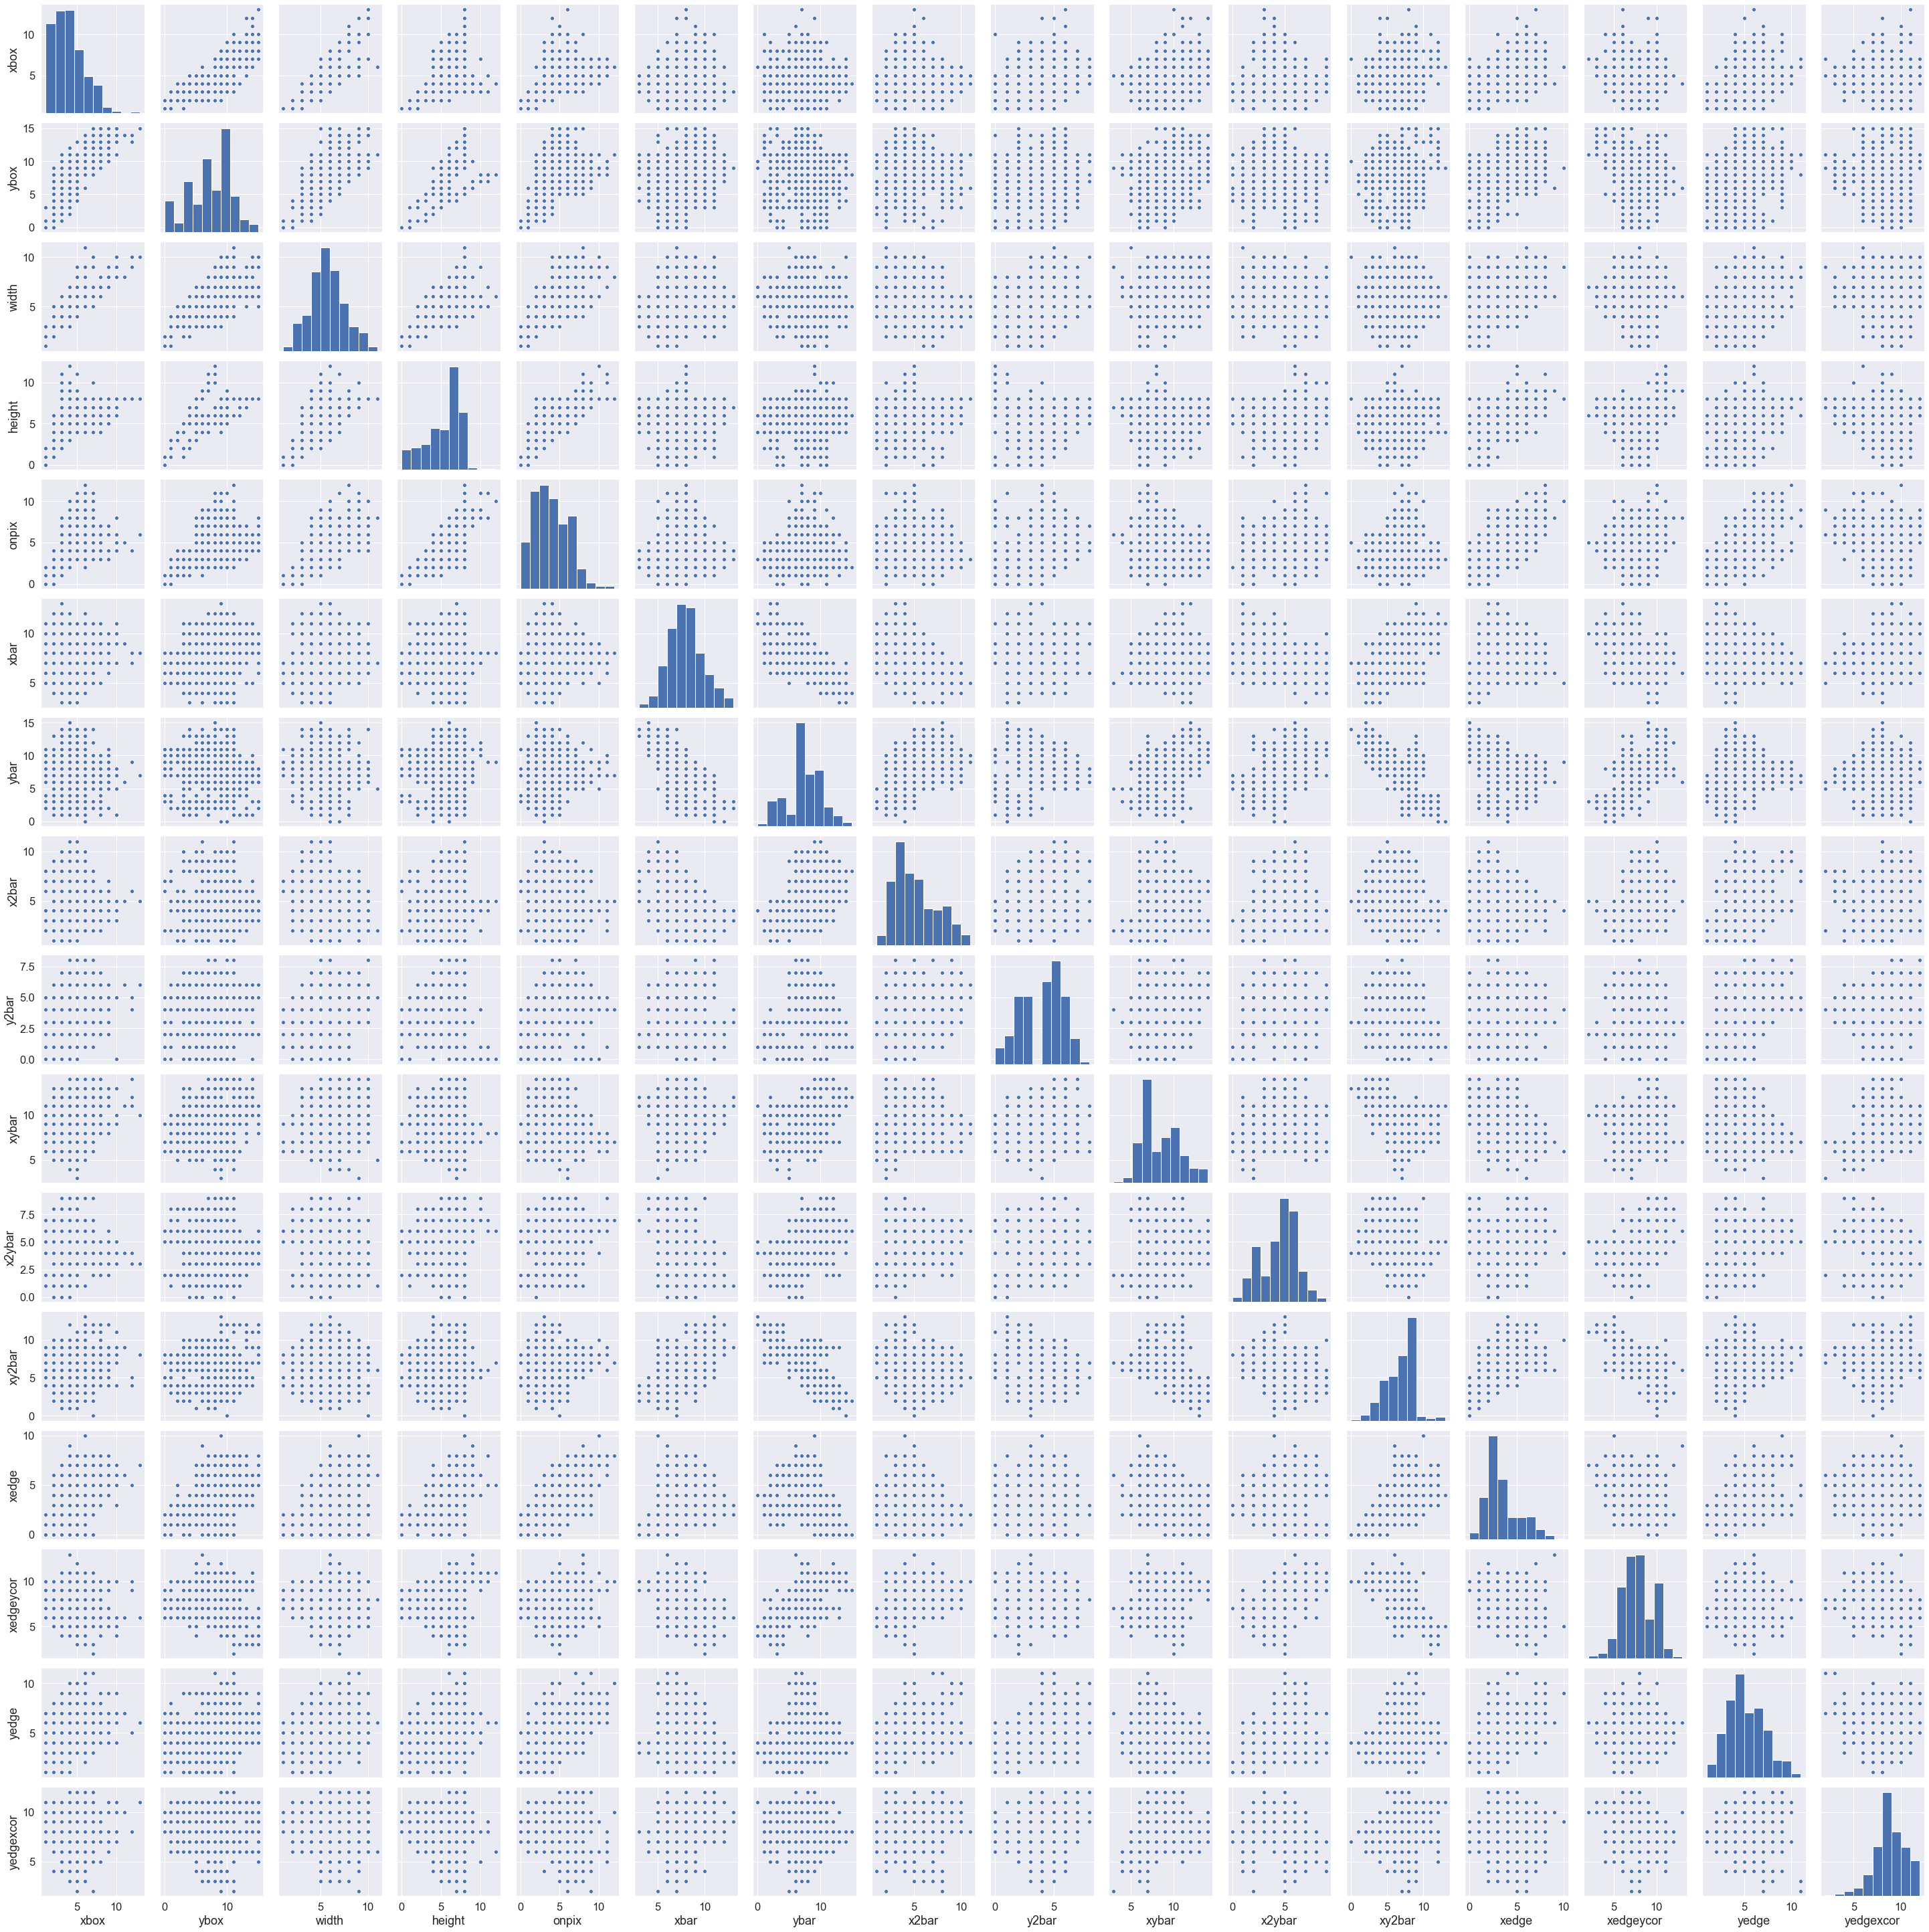

In [11]:
sns.pairplot(df.sample(1000))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

letter       0
xbox         0
ybox         0
width        0
height       0
onpix        0
xbar         0
ybar         0
x2bar        0
y2bar        0
xybar        0
x2ybar       0
xy2bar       0
xedge        0
xedgeycor    0
yedge        0
yedgexcor    0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

111

In [14]:
df[df.duplicated(keep=False)]

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgeycor,yedge,yedgexcor
4,P,3,6,4,4,2,4,14,8,1,11,6,3,0,10,4,8
48,B,4,9,4,6,3,6,7,9,7,7,6,7,2,8,9,10
49,A,1,3,2,2,1,10,3,2,1,9,2,9,1,6,1,8
50,P,1,0,1,0,0,5,10,6,1,9,6,5,0,9,2,8
67,B,1,0,1,0,0,7,7,6,4,7,6,7,1,8,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,R,2,0,2,1,1,6,10,7,2,7,5,8,2,7,4,10
3014,B,2,0,2,1,1,7,7,7,5,7,6,7,1,8,7,8
3015,A,1,0,2,0,0,8,3,2,0,7,2,8,2,6,1,8
3048,P,2,1,2,1,1,5,11,7,2,9,6,4,1,9,3,8


### Treat Imbalance Data

### Treat Outliers

### Treat Data Types

### Feature Scaling

In [15]:
df.columns

Index(['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar', 'ybar',
       'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge', 'xedgeycor',
       'yedge', 'yedgexcor'],
      dtype='object')

In [16]:
df = df[['xbox', 'ybox', 'width', 'height', 'onpix', 'xbar', 'ybar',
       'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge', 'xedgeycor',
       'yedge', 'yedgexcor','letter']]

In [17]:
df

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgeycor,yedge,yedgexcor,letter
0,4,2,5,4,4,8,7,6,6,7,6,6,2,8,7,10,B
1,1,1,3,2,1,8,2,2,2,8,2,8,1,6,2,7,A
2,5,9,5,7,6,6,11,7,3,7,3,9,2,7,5,11,R
3,5,9,7,7,10,9,8,4,4,6,8,6,6,11,8,7,B
4,3,6,4,4,2,4,14,8,1,11,6,3,0,10,4,8,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,2,3,3,1,1,6,2,2,1,5,2,8,1,6,1,7,A
3112,3,9,5,6,2,6,5,3,1,6,1,8,2,7,2,7,A
3113,2,3,3,2,2,7,7,5,5,7,5,6,2,7,4,8,R
3114,2,1,3,2,1,4,10,3,5,10,8,5,0,9,3,7,P


In [18]:
encoder = LabelEncoder()

In [19]:
df['letter'] = encoder.fit_transform(df['letter'])

In [20]:
df

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgeycor,yedge,yedgexcor,letter
0,4,2,5,4,4,8,7,6,6,7,6,6,2,8,7,10,1
1,1,1,3,2,1,8,2,2,2,8,2,8,1,6,2,7,0
2,5,9,5,7,6,6,11,7,3,7,3,9,2,7,5,11,3
3,5,9,7,7,10,9,8,4,4,6,8,6,6,11,8,7,1
4,3,6,4,4,2,4,14,8,1,11,6,3,0,10,4,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,2,3,3,1,1,6,2,2,1,5,2,8,1,6,1,7,0
3112,3,9,5,6,2,6,5,3,1,6,1,8,2,7,2,7,0
3113,2,3,3,2,2,7,7,5,5,7,5,6,2,7,4,8,3
3114,2,1,3,2,1,4,10,3,5,10,8,5,0,9,3,7,2


In [21]:
df['letter'].value_counts()

2    803
0    789
1    766
3    758
Name: letter, dtype: int64

### Create and save processed dataset

#### A is 0, B is 1, P is 2, R is 3

In [22]:
#df.to_csv("lettertrain.csv",index=False)

### Model Training

In [23]:
df.shape

(3116, 17)

In [24]:
X = df.iloc[:,0:16]
y = df.iloc[:,16]

In [25]:
X.values, y.values

(array([[ 4,  2,  5, ...,  8,  7, 10],
        [ 1,  1,  3, ...,  6,  2,  7],
        [ 5,  9,  5, ...,  7,  5, 11],
        ...,
        [ 2,  3,  3, ...,  7,  4,  8],
        [ 2,  1,  3, ...,  9,  3,  7],
        [ 4,  9,  6, ...,  7,  2,  8]], dtype=int64),
 array([1, 0, 3, ..., 3, 2, 0]))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2492, 16), (624, 16), (2492,), (624,))

### Using XGBoost

In [28]:
xgb = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [29]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='merror',early_stopping_rounds=10)

[0]	validation_0-merror:0.157051
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.116987
[2]	validation_0-merror:0.105769
[3]	validation_0-merror:0.126603
[4]	validation_0-merror:0.105769
[5]	validation_0-merror:0.096154
[6]	validation_0-merror:0.099359
[7]	validation_0-merror:0.096154
[8]	validation_0-merror:0.094551
[9]	validation_0-merror:0.092949
[10]	validation_0-merror:0.091346
[11]	validation_0-merror:0.091346
[12]	validation_0-merror:0.091346
[13]	validation_0-merror:0.084936
[14]	validation_0-merror:0.078526
[15]	validation_0-merror:0.081731
[16]	validation_0-merror:0.078526
[17]	validation_0-merror:0.073718
[18]	validation_0-merror:0.067308
[19]	validation_0-merror:0.065705
[20]	validation_0-merror:0.067308
[21]	validation_0-merror:0.064103
[22]	validation_0-merror:0.059295
[23]	validation_0-merror:0.059295
[24]	validation_0-merror:0.054487
[25]	validation_0-merror:0.048077
[26]	validation_0-merror:0.044872
[27]	validation_0-merror:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [30]:
y_pred = xgb.predict(X_test)

In [31]:
y_pred

array([3, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 3, 0, 2, 0, 0, 3, 0, 2, 3, 0, 0,
       0, 3, 3, 1, 1, 0, 2, 0, 3, 3, 3, 1, 3, 1, 1, 1, 1, 2, 2, 0, 0, 1,
       2, 2, 3, 0, 0, 1, 2, 0, 3, 0, 2, 0, 1, 1, 2, 2, 0, 3, 3, 1, 1, 0,
       3, 1, 0, 2, 1, 3, 1, 1, 2, 0, 2, 2, 2, 3, 1, 0, 2, 2, 3, 2, 2, 3,
       1, 0, 2, 0, 2, 0, 0, 3, 3, 3, 2, 2, 2, 3, 0, 2, 2, 3, 0, 1, 3, 0,
       1, 2, 2, 0, 3, 0, 2, 1, 3, 3, 1, 3, 1, 1, 1, 0, 3, 1, 1, 3, 2, 2,
       3, 1, 1, 0, 3, 2, 3, 3, 0, 2, 2, 1, 0, 1, 1, 0, 1, 2, 3, 0, 2, 1,
       2, 0, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 3, 1, 1, 1, 0, 1, 0,
       1, 3, 0, 2, 0, 0, 3, 1, 3, 3, 1, 3, 3, 3, 1, 2, 2, 3, 1, 1, 1, 1,
       1, 2, 2, 3, 1, 3, 1, 0, 3, 3, 3, 1, 1, 2, 1, 2, 3, 3, 1, 1, 1, 0,
       1, 2, 0, 0, 0, 2, 0, 0, 0, 3, 1, 3, 1, 0, 2, 0, 0, 0, 3, 2, 3, 2,
       2, 3, 3, 1, 2, 1, 2, 3, 2, 3, 3, 0, 2, 3, 3, 0, 3, 3, 3, 3, 0, 1,
       0, 2, 0, 1, 0, 3, 1, 3, 2, 0, 3, 2, 1, 1, 0, 0, 2, 1, 3, 1, 2, 2,
       2, 1, 3, 3, 1, 1, 0, 3, 3, 1, 0, 0, 2, 3, 0,

### Model Evaluation

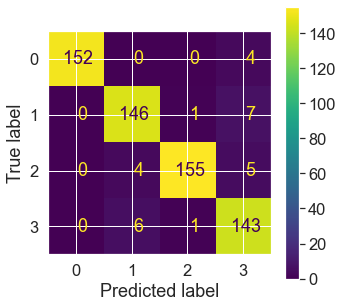

In [32]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgb,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       156
           1       0.94      0.95      0.94       154
           2       0.99      0.95      0.97       164
           3       0.90      0.95      0.93       150

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624



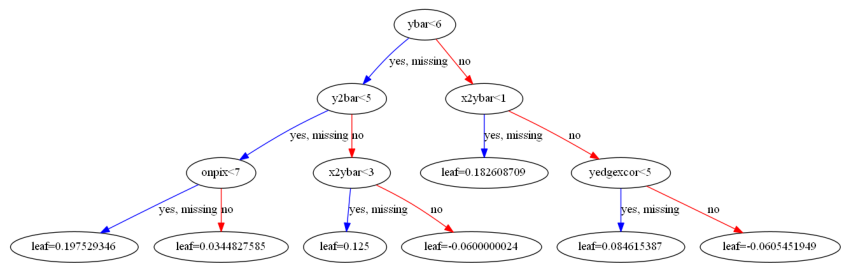

In [34]:
fig , ax = plt.subplots(figsize=(15,15))
plot_tree(xgb, ax=ax)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

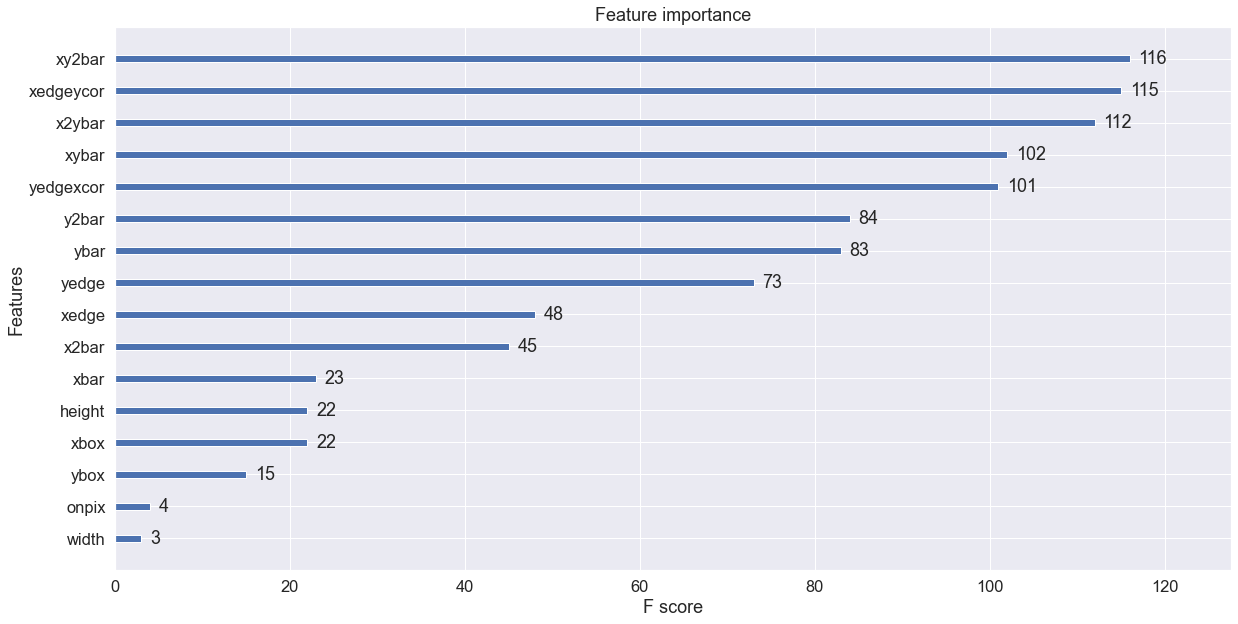

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax)
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [36]:
cv = cross_val_score(xgb,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


In [37]:
cv.mean()

0.9781794048647982